<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Linear_systems_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals
- Understand how iterative methods approach the solution through building a basis
- Be able to use Conjugate Gradient and GMRES

#Nomenclature

Capital letters are Matricies: $A$

Vectors have arrows above: $\vec{x}$

Scalars are lower case: $\alpha$

Superscripts generally denote iteration number: $\vec{x}^k$.

#Conjugate gradient (CG)

Conjugate gradient method is a standard tool for solving symmetric positive definite systems.

Consider a quadratic surface, defined by:

$f(\vec{x}^k) = \frac{1}{2} \vec{x}^T A \vec{x} -\vec{b}^T \vec{x}$.

This surface has a minimum at:

\begin{align}
\frac{d f}{ d x} = \vec{0} &= A \vec{x}-\vec{b} \\
\vec{0} &= \vec{r}
\end{align}

Where $\vec{r}=A \vec{x}-\vec{b} $ is the residual. Minimizing $f$ is equivilant to solving $A\vec{x} = \vec{b}$ which is equiviliant to finding $\vec{r}=\vec{0}$.

For a general guess $\vec{x}^k$,

\begin{align}
A \vec{x}^k-\vec{b} =\vec{r}^k \ne 0 \\
\end{align}









### The Hessian
Note: The matrix $A$ in this case is the *hessian*, $H$, of $f$, which is the matrix made by the mixed second derivatives:

$H = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$

From the rule of mixed second derivatives, we see that the Hessian is symmetric.

The Hessian is positive definite if $\vec{x}^T H \vec{x} > 0$ for all $\vec{x}$. In this case the quadratic surface $f$ is convex (opening upwards). For a 1D case, this means you have a positive second derivative.

> For comparison, the other common function with second derivatives is the Laplacian, which is a scalar sum of the diagonal elements of H: $\Delta f = \nabla^2 f = \frac{\partial^2 f}{\partial x_1^2} + \frac{\partial^2 f}{\partial x_2^2} + \frac{\partial^2 f}{\partial x_3^2} ... $

- Since $A$ is symmetric, you could form a surface $f$ which has an *extrenum* at the solution of the system. These problems are generally called *saddle point problem*.

- Since $A$ is symmetric positive definite, the surface is convex quadratic (paraboloid) which has a minimum at the solution of the linear system.


##The algorithm

Starting at $\vec{x}^k$, we will choose step direction $\vec{s}^k$, and step length $\alpha^k$ to reach our next guess $\vec{x}^{k+1}$:

$\vec{x}^{k+1} = \vec{x}^k + \alpha^k \vec{s}^k$


### Choose the step length

An obvious choice for $\alpha^k$ is whatever minimizes $f(\vec{x}^{k+1})$!

$f(\vec{x}+\alpha^k \vec{s}^k) = \frac{1}{2} [\vec{x}+\alpha^k \vec{s}^k]^T A [\vec{x}+\alpha^k \vec{s}^k] -\vec{b}^T [\vec{x}+\alpha^k \vec{s}^k]$.

The minimum is found when:

\begin{align}
\frac{\partial f}{\partial \alpha^k} = 0 &= {\vec{s}^k}^T A [\vec{x}+\alpha^k \vec{s}^k] -\vec{b}^T \vec{s}^k\\
&= {\vec{s}^k}^T A \vec{x}^k+ {\vec{s}^k}^T A \alpha^k \vec{s}^k -{\vec{s}^k}^T \vec{b} \\
&= {\vec{s}^k}^T [A \vec{x}^k-\vec{b}] + \alpha^k {\vec{s}^k}^T A  \vec{s}^k  \\
\alpha_k &= \frac{{\vec{s}^k}^T \vec{r}^k}{{\vec{s}^k}^T A  \vec{s}^k}
\end{align}



So given a step direction $\vec{s}^k$ we can take an optimal step length $\alpha_k$ which is determined by the current residual $\vec{r}^k$.

###Choose the step direction: Steepest descent

The magic of these methods comes from the choice of step direction.

How do we go about choosing $\vec{s}^k$?

The intuitive answer is the negative gradient of $f(x^k)$, which is simply,

$s^k = -\nabla f = -\frac{d f}{d\vec{x}} = -\vec{r}^k$

The optimal step size is therefore,

$\alpha_k=\frac{{\vec{r}^k}^T \vec{r}^k}{{\vec{r}^k}^T A \vec{r}^k}$

Now we take the step to form $\vec{x}^{k+1}$ and repeat the process until your choice of tolerance on the residual (or $\vec{x}^k$!) is met.

Let's code it!

In [1]:
# Copy the surface plotter from the last lecture:
import numpy as np
import matplotlib.pyplot as plt

def plot_surface(A, b, x0, x_true):
  # Utility function to autoscale the plot limits to include x0 and x_true
  def calculate_box_limits(point1, point2, padding=.5):
    # Extract coordinates
    x1, y1 = point1
    x2, y2 = point2
    # Calculate min and max coordinates with padding
    min_x = min(x1, x2) - padding
    max_x = max(x1, x2) + padding
    min_y = min(y1, y2) - padding
    max_y = max(y1, y2) + padding
    return (min_x, max_x, min_y, max_y)

  xb, xe, yb, ye = calculate_box_limits(x0, x_true)
  # Plot the linear system
  x = np.linspace(xb, xe, 100)
  y = np.linspace(yb, ye, 100)
  X, Y = np.meshgrid(x, y)
  V = np.stack((X,Y),-1)
  Z = 0.5 * (A[0, 0] * X**2 + A[1, 1] * Y**2 + 2 * A[0, 1] * X * Y) - (b[0] * X + b[1] * Y)
  fig, ax = plt.subplots()

  CS = ax.contour(X, Y, Z, levels = 15)
  ax.set_xlim([xb, xe])  # Set x-axis limits
  ax.set_ylim([yb, ye])  # Set y-axis limits
  ax.clabel(CS, inline=True, fontsize=10)

  return fig

In [2]:
# prompt: write a function to solve a linear system using the method of steepest descent

import numpy as np
def steepest_descent(A, b, x0, tol=1e-6, max_iter=100):
  """
  Solves a linear system Ax = b using the method of steepest descent.


  Args:
    A: The coefficient matrix (must be symmetric positive definite).
    b: The right-hand side vector.
    x0: The initial guess for the solution.
    tol: The tolerance for the residual.
    max_iter: The maximum number of iterations.

  Returns:
    x: The approximate solution.
    residuals: A list of the residuals at each iteration.
  """
  x = x0
  iterations = [x]
  for i in range(max_iter):
    r = A @ x - b
    if np.linalg.norm(r) < tol:
      break
    alpha = np.dot(r, r) / np.dot(r, A @ r)
    x = x - alpha * r
    print('Iteration ', i, ' : ',x)
    iterations.append(np.copy(x))
  return x, iterations


The true answer is  [0.81818182 1.72727273]
Iteration  0  :  [1.1380597  1.36567164]
Iteration  1  :  [0.78590538 1.65913358]
Iteration  2  :  [0.83080067 1.71300793]
Iteration  3  :  [0.81690855 1.72458471]
Iteration  4  :  [0.81867962 1.72671   ]
Iteration  5  :  [0.81813159 1.72716669]
Iteration  6  :  [0.81820146 1.72725053]
Iteration  7  :  [0.81817984 1.72726854]
Iteration  8  :  [0.81818259 1.72727185]
Iteration  9  :  [0.81818174 1.72727256]


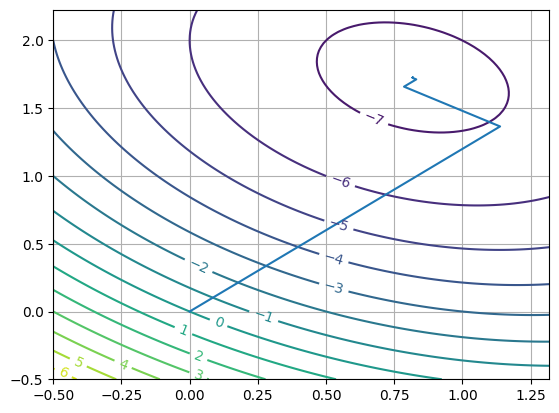

In [3]:
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

x_true = np.linalg.solve(A, b)
print('The true answer is ', x_true)

fig = plot_surface(A, b, x0, x_true)

_, iterations = steepest_descent(A, b, x0)

iterations = np.array(iterations)

plt.plot(iterations[:, 0], iterations[:, 1], marker='', linestyle='-')
plt.grid(True)
plt.show()

The approach results in the final $\vec{x}^{approx}$ (eg: after 9 iterations) being formed as:

$\vec{x}^{9} = \vec{x}^0 + \alpha^1 \vec{s}^1 + \alpha^2 \vec{s}^2 + \alpha^3 \vec{s}^3 ...$

Let's consider this for a minute. We are assembling the vector that moves from $\vec{x}^0$ to $~\vec{x}^9$, as a series of 9 steps in directions $\vec{s}^k$ with magnitude $\alpha^k$.

-> What does this expression remind you of?

This path is inefficient because you end up with zig-zagging where one step *undoes* some of the others which is inefficient.

-> How do we ensure the next step doesn't undo the previous step?

### Choose the step direction: Conjugate gradient

The problem is that certain steps undo the effect of the previous step(s). We can instead choose successive step directions to *not undo each other*, by requiring the next step be *conjugate* to each other.

This means we must base the $\vec{s}^{k+1}$ step on the $\vec{s}^{k}$ step and the gradient descent (which we just saw was $\vec{r}^k$).

$\vec{s}^{k+1} = \vec{r}^{k+1}+\beta^k \vec{s}^k$

and require that $\vec{s}^{k+1}$ and $\vec{s}^k$ are *conjugate to each other in $A$*:

${\vec{s}^{k+1}}^T A \vec{s}^k = 0$

This does not mean that $\vec{s}^{k+1}$ and $\vec{s}^k$ are orthogonal; rather vectors $\vec{s}^{k+1}$ and $A \vec{s}^k$ (or equivilantly $A \vec{s}^{k+1}$ and $\vec{s}^k$) are orthogonal.

We can then solve,

\begin{align}
[\vec{r}^{k+1}+\beta^k \vec{s}^k]^T A \vec{s}^k &= 0\\
\beta^k  &= -\frac{\vec{r}^{k+1} A \vec{s}^k}{{\vec{s}^k}^T A \vec{s}^k}
\end{align}

and so we find the next step direction,

$s^{k+1} = r^{k+1} -\frac{r^{k+1} A s^k}{{s^k}^T A s^k} s^k$.

The step length $\alpha_k$ is determined exactly as before.


Actually, we are going to make the new step direction conjugate to *all* the previous directions, so we have to say:

$\vec{s}^{k+1} = \vec{r}^{k+1} - \sum_{i<k}\frac{\vec{r}^{k+1} A \vec{s}^k}{{\vec{s}^k}^T A \vec{s}^k} \vec{s}^k$.


In [4]:
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

x_true = np.linalg.solve(A, b)
print('The true answer is ', x_true)

The true answer is  [0.81818182 1.72727273]


In [5]:
# prompt: call a cg solve on this system, but build a list of the iterations
from scipy.sparse.linalg import cg
import numpy as np

iterations = [x0]
print(x0)
def print_iteration_and_save(xk):
  iterations.append(np.copy(xk))
  print(xk)

solution, info = cg(A, b, x0=x0, callback=print_iteration_and_save)

[0. 0.]
[1.1380597  1.36567164]
[0.81818182 1.72727273]


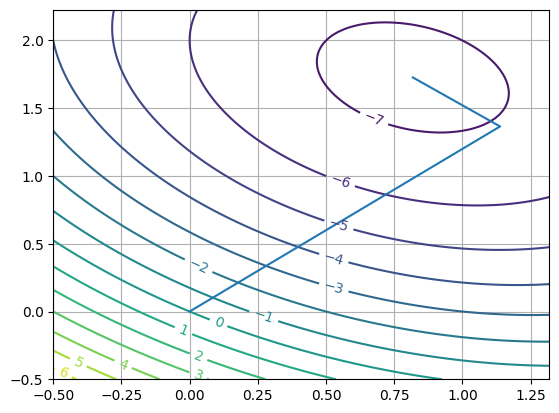

In [6]:
iterations = np.array(iterations)

fig = plot_surface(A, b, x0, x_true)

# Plot the iterations on a 2D surface
plt.plot(iterations[:, 0], iterations[:, 1], marker='', linestyle='-')
plt.grid(True)
plt.show()

Let's examine the steps, which we can find as the difference between successive iterations:

In [7]:
s1 = iterations[1,:]-iterations[0,:]
s2 = iterations[2,:]-iterations[1,:]
print(s1,s2)
print(np.dot(s1,s2))  #not zero
print(np.dot(s1,A@s2))  #Zero
print(np.dot(s2,A@s1))  #Zero

[1.1380597  1.36567164] [-0.31987788  0.36160109]
0.1297882196885316
6.661338147750939e-16
6.661338147750939e-16


Successive steps are conjugate in $A$ as expected.

Another interesting property is that the residual at each step is orthogonal:

In [8]:
r0 = A@iterations[0,:]-b
r1 = A@iterations[1,:]-b
r2 = A@iterations[2,:]-b

print(r0.dot(r1))
print(r1.dot(r2))

0.0
0.0


which helps with computational efficiency.

## Analysis

Beginning at $\vec{x}^0$, we are tasked with finding $\vec{x}^{approx}$ through an expansion:

$\vec{x}^{approx} - \vec{x}^0 =  \alpha^1 \vec{s}^1 + \alpha^2 \vec{s}^2 + ...$.

but this is simply vector addition using a set of directions. Our algorithms has generated the directions $\vec{s}^k$ which form a set of *vector bases* for:

$\vec{x}^{approx} - \vec{x}^0$

and, at the same time, the corresonding *components*, the $\alpha^k$.

- The method of steepest descent doesn't enforce all vector bases be orthogonal (or conjugate), resulting in frenetic zig-zagging and more bases than necessary.

- The conjugate gradient method enforces conjugacy in the vector bases such that they don't overlap. Vectors are linearly independent from the matrix-vector products of the others. This algorithm relies on $A$ being SPD.


>Note that these techniques only ever use $A$ in the context for a matrix-vector product - $A \vec{x}$. Matrix-vector products are $O(n^2)$ (for dense matricies, better for sparse) but there is also the storage requirement for $A$. If we can find a better way to get the vector $A\vec{x}$ that doesn't involve (assembling), storing, and multiplying $A$, we can see improvements. This is the basis of **Matrix-free** algorithms.

Note the *space* of the solution vector $x$ is just its dimension $n$, and if CG determins linearly independent vectors, it can only find, at most $n$! Therefore, CG will find the exact solution in $n$ iterations (baring roundoff error) which some may take to imply it is a *direct method*. However, the situation is even better, which qualifies it as an iterative technique! Let's see what happens with a larger system:

In [29]:
# prompt: Solve a 10x10 random spd linear system with CG

import numpy as np
from scipy.sparse.linalg import cg

n = 8
A_r = np.random.rand(n, n)
A_rand = A_r @ A_r.T  # Ensure A is symmetric positive definite
b_rand = np.random.rand(n)
x0_rand = np.zeros(n)


class it_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

np.set_printoptions(precision=4)

solution, info = cg(A_rand, b_rand, x0=x0_rand, atol = 1e-6, rtol = 1e-10, callback = it_counter())
print("Solution:", solution)
print("Info:", info)


iter   1	rk = [0.0209 0.0075 0.032  0.0783 0.0439 0.0073 0.0369 0.0801]
iter   2	rk = [-0.8925 -1.2871 -0.2747  1.7474  1.0466 -0.8757  0.0896  1.3888]
iter   3	rk = [-1.1486 -1.8634 -0.5373  1.7162  1.341  -0.7321  0.404   1.9777]
iter   4	rk = [-1.2676 -2.5568 -0.1426  1.5324  2.2171 -0.4695  0.4377  1.9871]
iter   5	rk = [-2.2603 -2.864   0.6716  1.1551  3.1509 -0.1319  0.5006  2.1877]
iter   6	rk = [-2.9958 -2.8345  0.9681  0.9131  4.1145 -0.3175  1.4379  1.8352]
iter   7	rk = [-2.9739 -2.8203  1.0523  0.7471  4.2074 -0.5366  1.4883  1.9233]
iter   8	rk = [-2.9605 -2.7277  0.9849  0.6628  4.3529 -0.6061  1.4368  1.9791]
iter   9	rk = [-2.9605 -2.7277  0.9849  0.6628  4.3529 -0.6061  1.4368  1.9791]
Solution: [-2.9605 -2.7277  0.9849  0.6628  4.3529 -0.6061  1.4368  1.9791]
Info: 0


Note that successive iterations are getting closer and closer. Usually, the estimates converge before $n$ iterations (which is especially useful for large sparse matricies!)

###Restart

Sometimes, the set of $s^k$ gets too large and round-off error can accumulate. Therefore, some implementation have an integer 'restart' parameter which will trigger a restart of the bases after a set number have been generated.

# Generalized Minimal Residual Method (GMRES)

Let's finally turn our attention towards the general case of $A$ being a general non-symmetric matrix. Since it is non-symmetric, it can not be a Hessian and there is no quadratic surface associated with it.

We can adapt the same basic method of CG:
- Take the residual of the system, $\vec{r} = A\vec{x}-\vec{b}$ and minimize its Euclidian norm, $||\vec{r}||$.
- Beginning with $\vec{x}^0$, construct a basis for $\vec{x}^{approx}-\vec{x}^0$ in $\vec{s}^k$.
- Enforce orthogonality with successive $\vec{s}^{k}$
- Since each $\vec{s}^k$ is linearly independent, the method will converge in at most $n$ iterations, but typically converges much sooner.
- A restart may still be necessary to control memory consumption for large systems.

The major difference is that the conjugacy of $\vec{s}^k$ is not possible since $A$ is not SPD. Rather, $\vec{s}^k$ are chosen to be orthogonal which is a more general, but less powerful condition.

In [20]:
from scipy.sparse.linalg import gmres
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])


iterations = [x0]
print(x0)
def print_iteration_and_save(xk):
  iterations.append(np.copy(xk))
  print(xk)

solution, info = gmres(A, b, callback=it_counter(), callback_type = 'legacy')  #x
np.linalg.solve(A,b)
print(iterations)

[0. 0.]
iter   1	rk = 0.15122563463888616
iter   2	rk = 7.674967607276873e-17
[array([0., 0.])]


In [30]:
np.set_printoptions(precision=4)

solution, info = gmres(A_rand, b_rand, x0=x0_rand, atol = 1e-6, rtol = 1e-10, callback = it_counter(), callback_type='legacy')
print("Solution:", solution)
print("Info:", info)

iter   1	rk = 0.6009604017495943
iter   2	rk = 0.3918500855823959
iter   3	rk = 0.20243617177538392
iter   4	rk = 0.15688283627620023
iter   5	rk = 0.10599045198232475
iter   6	rk = 0.0398441273250505
iter   7	rk = 0.022361032564208502
iter   8	rk = 2.2495773485670963e-15
Solution: [-2.9605 -2.7277  0.9849  0.6628  4.3529 -0.6061  1.4368  1.9791]
Info: 0
